In [1]:
#####Timescale Poisson Factorization#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [2]:
####データの発生####
##データの設定
k = 10   #基底数
hh = 5000   #ユーザー数
item = 3000   #アイテム数
pt = np.random.poisson(np.random.gamma(25.0, 1/0.2, hh), hh)   #ユーザーあたりのレコード数
hhpt = np.sum(pt)   #総レコード数
vec_k = np.repeat(1, k)

In [3]:
##IDとインデックスを設定
#IDを設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
user_vec = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
    user_vec[i] = np.repeat(1, pt[i])

In [4]:
##アイテムの割当を生成
#セグメント割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, item), topic)
theta = np.random.dirichlet(np.repeat(2.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
    
#インデックスの設定
item_list = [j for j in range(item)]
item_vec = [j for j in range(item)]
item_n = np.repeat(0, item)
for j in range(item):
    item_list[j] = index[item_id==j]
    item_vec[j] = np.repeat(1, len(item_list[j]))
    item_n[j] = len(item_list[j])

0
1000
2000
3000
4000


In [5]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k1 = 3; k2 = 5; k3 = 5
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
col_u = u.shape[1]

#アイテムの説明変数を生成
k1 = 4; k2 = 5; k3 = 4
v1 = np.array(np.random.random(item*k1)).reshape((item, k1))
v2 = np.zeros((item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)
col_v = v.shape[1]

In [6]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    
    #ガンマ分布から継続時間を生成
    alpha1 = 20.0
    alpha2 = 0.15
    period = np.array(np.random.gamma(alpha1, 1/alpha2, hh), dtype="int")
    period_vec = period[user_id]
    
    ##ランダム効果のパラメータを生成
    #階層モデルのパラメータを生成
    tau1 = 0.3; tau2 = 0.3
    alpha1 = np.random.normal(0, 0.5, col_u)
    alpha2 = np.random.normal(0, 0.5, col_v)
    taut1 = tau1; taut2 = tau2
    alphat1 = alpha1.copy(); alphat2 = alpha2.copy()
    
    #正規分布からランダム効果を生成
    lambda1 = np.dot(u, alpha1)
    lambda2 = np.dot(v, alpha2)
    w1 = lambda1 + np.random.normal(0, tau1, hh)
    w2 = lambda2 + np.random.normal(0, tau2, item)
    wt1 = w1.copy(); wt2 = w2.copy()

    ##NMFのパラメータを生成
    #ガンマ分布の尺度パラメータを生成
    alpha_u = np.random.normal(0, 0.4, k*col_u).reshape(col_u, k)
    alpha_v = np.random.normal(0, 0.4, k*col_v).reshape(col_v, k)
    alpha_ut = alpha_u; alpha_vt = alpha_v
    lambda_u = np.exp(np.dot(u, alpha_u))
    lambda_v = np.exp(np.dot(v, alpha_v))

    #ガンマ分布の形状パラメータを生成
    beta_u = np.abs(np.random.normal(1.0, 0.5, 1))
    beta_v = np.abs(np.random.normal(1.0, 0.5, 1))
    beta_ut = beta_u; beta_vt = beta_v

    #ガンマ分布から行列分解のパラメータを生成
    theta_u = np.random.gamma(lambda_u, 1/beta_u)
    theta_v = np.random.gamma(lambda_v, 1/beta_v)
    theta_ut = theta_u; theta_vt = theta_v

    ##指数分布から応答変数を生成
    dim = 200
    WH = np.exp(w1[user_id] + w2[item_id]) + np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)
    y_dt = np.zeros((hhpt, dim))
    for j in range(dim):
        y_dt[:, j] = np.random.exponential(WH, hhpt)
    y = np.sum(np.cumsum(y_dt, axis=1) < period[user_id].reshape(hhpt, 1), axis=1)
    y_vec = y.reshape(hhpt, 1)
    
    #break条件
    print(np.array([rp, np.max(y), np.sum(y==0)]))
    if (np.max(y) < 200) & (np.max(y) > 75) & (np.sum(y==0) > 25000) & (np.sum(y==0) < 150000):
        break

[    1   200 20622]
[     2      2 624910]
[   3  200 2510]
[   4  200 2106]
[   5  200 4994]
[   6  199 6401]
[   7  176 8899]
[    8   139 10757]
[    9   126 20970]
[    10     91 216496]
[  11  200 1022]
[   12   150 49853]


In [7]:
#打ち切り変数を設定
censor_y = period[user_id] - np.sum(y_dt * (np.cumsum(y_dt, axis=1) < period[user_id].reshape(hhpt, 1)), axis=1)
last_y = np.sum(y_dt * (np.cumsum(y_dt, axis=1) < period[user_id].reshape(hhpt, 1)), axis=1)

3054191
4.8718328686186805


(array([5.99893e+05, 2.43360e+04, 2.14300e+03, 3.82000e+02, 1.03000e+02,
        3.10000e+01, 9.00000e+00, 6.00000e+00, 2.00000e+00, 3.00000e+00]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.]),
 <a list of 10 Patch objects>)

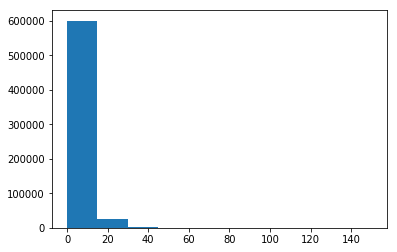

In [8]:
#生成した応答変数を確認
print(np.sum(y))
print(np.mean(y))
plt.hist(y)

In [9]:
##検証用データを生成

In [10]:
####マルコフ連鎖モンテカルロ法でMixed effect Poisson Factorizationを推定####
##ユーザーの変量効果の事後分布を推定するための関数
#モデルの対数事後分布を計算する関数
def loglike1(w1, w2, WH, Lambda, tau, y, index, user_id, n):
    #期待値を設定
    mu = w1[user_id] + w2 + WH
    
    #対数尤度と対数事前分布
    LLho = -mu - y*np.exp(-mu)   #指数分布の対数尤度
    log_normal = -1/2 * (np.power(w1 - Lambda, 2) / tau)   #正規分布の対数事前分布

    #対数事後分布の和
    Posterior = np.repeat(0.0, n)
    for i in range(n):
        Posterior[i] = np.sum(LLho[index[i]]) + log_normal[i]
    return Posterior

#変量効果の勾配係数の勾配を計算する関数
def dloglike1(w1, w2, WH, Lambda, tau, y, index, user_id, n):
    #期待値を設定
    mu = w1[user_id] + w2 + WH
    
    #対数尤度と対数事前分布の勾配
    dll = -(1 - y * np.exp(-mu))   #対数尤度の勾配
    dnorm = - (w1 - Lambda) / tau   #対数事前分布の勾配

    #対数事後分布の勾配の和
    LLd = np.repeat(0.0, n)
    for i in range(n):
        LLd[i] = np.sum(dll[index[i]]) + dnorm[i]
    return -LLd

#リープフロッグ法を解く関数
def leapfrog1(r, z1, D, e, L, w2, WH, Lambda, tau, y, index, user_id, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, w2, WH_log, lambda1, tau1, y, user_list, user_id, hh) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, w2, WH_log, lambda1, tau1, y, user_list, user_id, hh) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [11]:
##アイテムの変量効果の事後分布を推定するための関数
#モデルの対数事後分布を計算する関数
def loglike2(w2, w1, WH, Lambda, tau, y, index, user_id, n):
    #期待値を設定
    mu = w1 + w2[item_id] + WH
    
    #対数尤度と対数事前分布
    LLho = -mu - y*np.exp(-mu)   #指数分布の対数尤度
    log_normal = -1/2 * (np.power(w2 - Lambda, 2) / tau)   #正規分布の対数事前分布

    #対数事後分布の和
    Posterior = np.repeat(0.0, n)
    for i in range(n):
        Posterior[i] = np.sum(LLho[index[i]]) + log_normal[i]
    return Posterior

#変量効果の勾配係数の勾配を計算する関数
def dloglike2(w2, w1, WH, Lambda, tau, y, index, user_id, n):
    #期待値を設定
    mu = w1 + w2[item_id] + WH
    
    #対数尤度と対数事前分布の勾配
    dll = -(1 - y * np.exp(-mu))   #対数尤度の勾配
    dnorm = - (w2 - Lambda) / tau   #対数事前分布の勾配

    #対数事後分布の勾配の和
    LLd = np.repeat(0.0, n)
    for i in range(n):
        LLd[i] = np.sum(dll[index[i]]) + dnorm[i]
    return -LLd

#リープフロッグ法を解く関数
def leapfrog2(r, z1, D, e, L, w1, WH, Lambda, tau, y, index, user_id, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, w1, WH_log, lambda2, tau2, y, item_list, item_id, item) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, w1, WH_log, lambda2, tau2, y, item_list, item_id, item) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [12]:
##HMCで尺度パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_alpha(alpha, beta, tau_inv, d, d_log, x):

    #ガンマ回帰モデルの対数尤度
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = np.sum(beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log)

    #多変量正規分布の対数事前分布
    log_mvn = -1/2 * np.dot(np.dot(alpha, tau_inv), alpha)

    #対数事後分布の和
    LL = Lho + log_mvn
    return LL

#ガンマ回帰の対数事後分布の微分関数
def dloglike_alpha(alpha, beta, tau_inv, d, d_log, x, n):

    #期待値の設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)

    #微分関数の設定
    dlgamma = np.sum(((d-Lambda) / (np.power(Lambda, 2)/beta) * Lambda).reshape(n, 1) * x, axis=0)
    dmvn = np.dot(-tau_inv, alpha)

    #対数事後分布の微分関数の和
    LLd = -(dlgamma + dmvn)
    return LLd

#リープフロッグ法を解く関数
def leapfrog_alpha(r, z1, D, e, L, beta, tau_inv, d, d_log, x, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, beta, tau_inv, d, d_log, x, n) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, beta, tau_inv, d, d_log, x, n) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [13]:
##HMCで形状パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_beta(beta, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k):

    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #ガンマ回帰モデルの対数尤度
    Lho1 = np.sum(beta_u * (-d1/Lambda_u - mu_u) + beta_u*np.log(beta_u) - math.lgamma(beta_u) + (beta_u-1)*d_log1)
    Lho2 = np.sum(beta_v * (-d2/Lambda_v - mu_v) + beta_v*np.log(beta_v) - math.lgamma(beta_v) + (beta_v-1)*d_log2)

    #対数事後分布の和
    LL = Lho1 + Lho2
    return LL

#形状パラメータの微分関数
def dloglike_beta(beta, alpha_u, alpha_v, d1, d2, u, v, hh, item, k):
    
    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #微分関数の和
    dlgamma_u = (hh*k)*(np.log(beta_u) - scipy.special.digamma(beta_u)) + np.sum(1 - d1/Lambda_u + np.log(d1/Lambda_u))
    dlgamma_v = (item*k)*(np.log(beta_v) - scipy.special.digamma(beta_v)) + np.sum(1 - d2/Lambda_v + np.log(d2/Lambda_v))
    dlgamma = -np.append(dlgamma_u, dlgamma_v)
    return dlgamma

#リープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [14]:
##切断指数分布の乱数を生成する関数
def rtexp(gamma, a, b):
    #切断指数分布の乱数を生成
    FA = scipy.stats.expon.cdf(a, scale=gamma)
    FB = scipy.stats.expon.cdf(b, scale=gamma)
    par = scipy.stats.expon.ppf(np.random.uniform(0, 1, a.shape[0])*(FB-FA)+FA, scale=gamma)
    return par

In [15]:
##アルゴリズムの設定
R = 2000
keep = 4
burnin = int(500/keep)
iter = 0
disp = 10
e1 = 0.001
e2 = 0.0025
L = 3

In [16]:
##事前分布の設定
#モデルパラメータの事前分布
gamma1 = np.repeat(0, col_u)
gamma2 = np.repeat(0, col_v)
kappa1 = np.diag(np.repeat(100, col_u))
kappa2 = np.diag(np.repeat(100, col_v))
kappa_inv1 = np.linalg.inv(kappa1)
kappa_inv2 = np.linalg.inv(kappa2)

#ガンマ分布のハイパーパラメータの設定
par = 250
omega1 = par/pt.reshape(hh, 1); omega1[omega1 < 1, ] = 1
omega2 = par/item_n.reshape(item, 1); omega2[omega2 < 1] = 1

#逆ガンマ分布のハイパーパラメータの設定
s0 = 1
v0 = 1

In [17]:
##パラメータの真値
#ランダム効果の真値
alpha1 = alphat1; alpha2 = alphat2
tau1 = taut1; tau2 = taut2
lambda1 = np.dot(u, alpha1)
lambda2 = np.dot(v, alpha2)
w1 = wt1; w2 = wt2

#ガンマ分布の尺度パラメータの真値
alpha_u = alpha_ut; alpha_v = alpha_vt
lambda_u = np.exp(np.dot(u, alpha_u))
lambda_v = np.exp(np.dot(v, alpha_v))

#ガンマ分布の形状パラメータの真値
beta_u = beta_ut
beta_v = beta_vt

#行列分解のパラメータの真値
theta_u = theta_ut
theta_v = theta_vt
WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   #期待値

In [18]:
##パラメータの初期値
#ランダム効果の初期値
alpha1 = np.random.normal(0, 0.5, col_u)
alpha2 = np.random.normal(0, 0.5, col_v)
tau1 = 0.5; tau2 = 0.5
lambda1 = np.dot(u, alpha1)
lambda2 = np.dot(v, alpha2)
w1 = lambda1 + np.random.normal(0, tau1, hh)
w2 = lambda2 + np.random.normal(0, tau2, item)

#ガンマ分布の尺度パラメータの初期値
alpha_u = np.random.normal(0, 0.5, k*col_u).reshape(col_u, k)
alpha_v = np.random.normal(0, 0.5, k*col_v).reshape(col_v, k)
lambda_u = np.exp(np.dot(u, alpha_u))
lambda_v = np.exp(np.dot(v, alpha_v))

#ガンマ分布の形状パラメータを初期値
beta_u = 1.25
beta_v = 1.25

#ガンマ分布から行列分解のパラメータを生成
theta_u = np.random.gamma(lambda_u, 1/beta_u)
theta_v = np.random.gamma(lambda_v, 1/beta_v)
WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   #期待値

In [19]:
##サンプリング結果の格納用配列
WU = np.zeros((int(R/keep), hh))
WV = np.zeros((int(R/keep), item))
THETA_U = np.zeros((hh, k, int(R/keep)))
THETA_V = np.zeros((item, k, int(R/keep)))
ALPHA1 = np.zeros((int(R/keep), col_u))
ALPHA2 = np.zeros((int(R/keep), col_v))
ALPHA_U = np.zeros((col_u, k, int(R/keep)))
ALPHA_V = np.zeros((col_v, k, int(R/keep)))
TAU1 = np.zeros((int(R/keep)))
TAU2 = np.zeros((int(R/keep)))
BETA_U = np.zeros((int(R/keep)))
BETA_V = np.zeros((int(R/keep)))

In [20]:
##データの設定
#定数を設定
max_y = np.power(10, 10)
y_lfactorial = scipy.special.gammaln(y + 1)
inv_XXV1 = np.linalg.inv(np.dot(u.T, u) + kappa_inv1)
inv_XXV2 = np.linalg.inv(np.dot(v.T, v) + kappa_inv2)

#スパース行列作成用のid
no_id = np.repeat(np.arange(hhpt), k)
k_id = np.repeat(np.arange(k), hhpt).reshape(hhpt, k, order="F").reshape(-1)

#個別に和を取るためのスパース行列
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()

In [21]:
##対数尤度の基準値
#初期値の対数尤度
log_mu = w1[user_id] + w2[item_id] + np.log(np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k))
weights = scipy.stats.expon.cdf(censor_y, scale=np.exp(log_mu))
duration = period_vec / (y + weights)
LL = np.sum(-log_mu - duration*np.exp(-log_mu))

#1パラメータモデルの対数尤度
log_mu = np.log(period[user_id] * np.mean(y / period[user_id]))
weights = scipy.stats.expon.cdf(censor_y, scale=np.exp(log_mu))
duration = period_vec / (y + weights)
LLst = np.sum(-log_mu - duration*np.exp(-log_mu))

#真値での対数尤度
log_mu = wt1[user_id] + wt2[item_id] + np.log(np.dot(theta_ut[user_id, ] * theta_vt[item_id, ], vec_k))
weights = scipy.stats.expon.cdf(censor_y, scale=np.exp(log_mu))
duration = period_vec / (y + weights)
LLbest = np.sum(-log_mu - duration*np.exp(-log_mu))
print(np.array([LL, LLbest, LLst]))

[-8760537.72379379 -4843825.55377178 -6183289.47146056]


In [22]:
####MCMCでパラメータをサンプリング####
for rp in range(R):
    
    ##指数分布の累積分布から潜在変数を生成
    #指数分布の期待値
    w_mu = np.exp(w1[user_id] + w2[item_id])
    WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   
    mu = w_mu + WH
    
    #重み付き係数を設定
    weights = scipy.stats.expon.cdf(censor_y, scale=mu)
    duration = period_vec / (y + weights)
    duration_vec = duration.reshape(hhpt, 1)
    
    
    ##ユーザー特徴行列をサンプリング
    #補助変数gammaを更新
    theta_vec2 = theta_v[item_id, ]
    gamma = (theta_u[user_id, ] * theta_vec2) / mu.reshape(hhpt, 1)
    
    #ユーザーごとのガンマ分布のパラメータを設定
    gamma_y = gamma * duration_vec
    W1 = np.zeros((hh, k)); W2 = np.zeros((hh, k))
    for i in range(hh):
        W1[i, ] = np.dot(gamma_y[user_list[i], ].T, user_vec[i]) 
        W2[i, ] = np.dot(theta_vec2[user_list[i], ].T, user_vec[i])

    #ガンマ分布よりパラメータをサンプリング
    theta_u = np.random.gamma(W1 + omega1*lambda_u, 1 / (W2 + omega1*beta_u))
    theta_u = theta_u / np.repeat(np.sum(theta_u, axis=0), hh).reshape(hh, k, order="F") * hh * k
    
    
    ##アイテム特徴行列をサンプリング
    #補助変数gammaを更新
    theta_vec1 = theta_u[user_id, ]
    WH = np.dot(theta_vec1 * theta_vec2, vec_k)   
    mu = w_mu + WH
    gamma = (theta_vec1 * theta_vec2) / mu.reshape(hhpt, 1)

    #ユーザーごとのガンマ分布のパラメータを設定
    gamma_y = gamma * duration_vec
    H1 = np.zeros((item, k)); H2 = np.zeros((item, k))
    for j in range(item):
        H1[j, ] = np.dot(gamma_y[item_list[j], ].T, item_vec[j]) 
        H2[j, ] = np.dot(theta_vec1[item_list[j], ].T, item_vec[j])

    #ガンマ分布よりパラメータをサンプリング
    theta_v = np.random.gamma(H1 + omega2*lambda_v, 1 / (H2 + omega2*beta_v))
    
    
    ##ユーザーのランダム効果をサンプリング
    #HMCの新しいパラメータを生成
    WH_log = np.log(WH)
    w2_vec = w2[item_id]
    rold = np.random.normal(0, 1, hh)
    w_old1 = w1.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog1(rold, w_old1, dloglike1, e1, L, w2_vec, WH_log, lambda1, tau1, duration, user_list, user_id, hh)
    rnew = res[0]
    w_new1 = res[1]

    #移動前と移動後のハミルトニアン
    Hnew = -loglike1(w_new1, w2_vec, WH_log, lambda1, tau1, duration, user_list, user_id, hh) + np.sum(np.power(rnew, 2)) / 2
    Hold = -loglike1(w_old1, w2_vec, WH_log, lambda1, tau1, duration, user_list, user_id, hh) + np.sum(np.power(rnew, 2)) / 2
    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, hh)
    accept_prob = np.min(np.hstack((np.repeat(1, hh).reshape(hh, 1), np.exp(Hold - Hnew).reshape(hh, 1))), axis=1)   #採択率
    accept_prob1 = accept_prob.copy()

    #採択率に基づきthetaを採択
    flag = np.array(accept_prob > rand, dtype="int")
    w1 = flag*w_new1 + (1-flag)*w_old1
    
    
    ##アイテムのランダム効果をサンプリング
    #HMCの新しいパラメータを生成
    w1_vec = w1[user_id]
    rold = np.random.normal(0, 1, item)
    w_old2 = w2.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog2(rold, w_old2, dloglike2, e1, L, w1_vec, WH_log, lambda2, tau2, duration, item_list, item_id, item)
    rnew = res[0]
    w_new2 = res[1]

    #移動前と移動後のハミルトニアン
    Hnew = -loglike1(w_new2, w1_vec, WH_log, lambda2, tau2, duration, item_list, item_id, item) + np.sum(np.power(rnew, 2)) / 2
    Hold = -loglike1(w_old2, w1_vec, WH_log, lambda2, tau2, duration, item_list, item_id, item) + np.sum(np.power(rnew, 2)) / 2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, item)
    accept_prob = np.min(np.hstack((np.repeat(1, item).reshape(item, 1), np.exp(Hold - Hnew).reshape(item, 1))), axis=1)   #採択率
    accept_prob2 = accept_prob.copy()

    #採択率に基づきthetaを採択
    flag = np.array(accept_prob > rand, dtype="int")
    w2 = flag*w_new2 + (1-flag)*w_old2
    
    
    ##ガンマ分布の階層モデルのパラメータをサンプリング
    #採択率の格納用ベクトル
    accept_prob_u = np.repeat(0.0, k)
    accept_prob_v = np.repeat(0.0, k)

    for j in range(k):
        ##ユーザー特徴行列の尺度パラメータをサンプリング
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, col_u)
        alphad = alpha_u[:, j]

        #リープフロッグ法による1ステップ移動
        d = theta_u[:, j]; d_log = np.log(d)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta_u, kappa_inv1, d, d_log, u, hh)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta_u, kappa_inv1, d, d_log, u) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta_u, kappa_inv1, d, d_log, u) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_u[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_u[:, j] = alphan
        else:
            alpha_u[:, j] = alphad

        ##アイテム特徴行列の尺度パラメータをサンプリング
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, col_v)
        alphad = alpha_v[:, j]

        #リープフロッグ法による1ステップ移動
        d = theta_v[:, j]; d_log = np.log(d)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta_v, kappa_inv2, d, d_log, v, item)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta_v, kappa_inv2, d, d_log, v) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta_v, kappa_inv2, d, d_log, v) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_v[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_v[:, j] = alphan
        else:
            alpha_v[:, j] = alphad

        #lambdaを更新
        lambda_u = np.exp(np.dot(u, alpha_u))
        lambda_v = np.exp(np.dot(v, alpha_v))


        ##尺度パラメータをサンプリング
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, 2)
        betad = np.append(beta_u, beta_v)

        #リープフロッグ法による1ステップ移動
        d1 = theta_u.reshape(-1); d2 = theta_v.reshape(-1)
        res = leapfrog_beta(rold, betad, dloglike_beta, e2, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k)
        rnew = res[0]
        betan = res[1]

        #移動前と移動後のハミルトニアン
        d_log1 = np.log(d1); d_log2 = np.log(d2)
        Hnew = -loglike_beta(betan, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_beta(betad, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_a = accept_prob

        #採択率に基づきgammaを採択
        if(accept_prob >= rand):
            beta = betan
            beta_u = beta[0]; beta_v = beta[1]
        else:
            beta = betad
            beta_u = beta[0]; beta_v = beta[1]


    ##変量効果の階層モデルのパラメータをサンプリング
    #ユーザーの回帰パラメータをサンプリング
    Xy = np.dot(u.T, w1)
    alpha_mu = np.dot(inv_XXV1, Xy + np.dot(kappa_inv1, gamma1))
    alpha1 = np.random.multivariate_normal(alpha_mu, inv_XXV1, 1).reshape(-1)
    lambda1 = np.dot(u, alpha1)

    #アイテムの回帰パラメータをサンプリング
    Xy = np.dot(v.T, w2)
    alpha_mu = np.dot(inv_XXV2, Xy + np.dot(kappa_inv2, gamma2))
    alpha2 = np.random.multivariate_normal(alpha_mu, inv_XXV2, 1).reshape(-1)
    lambda2 = np.dot(v, alpha2)

    #逆ガンマ分布からユーザーの標準偏差をサンプリング
    er = w1 - lambda1
    gamma_s = np.sum(np.power(er - np.mean(er), 2)) + s0
    gamma_v = hh + v0
    tau1 = np.sqrt(1/np.random.gamma(gamma_v/2, 1/(gamma_s/2), 1))

    #逆ガンマ分布からアイテムの標準偏差をサンプリング
    er = w2 - lambda2
    gamma_s = np.sum(np.power(er - np.mean(er), 2)) + s0
    gamma_v = item + v0
    tau2 = np.sqrt(1/np.random.gamma(gamma_v/2, 1/(gamma_s/2), 1))


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        WU[mkeep, ] = w1
        WV[mkeep, ] = w2
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        ALPHA1[mkeep, ] = alpha1
        ALPHA2[mkeep, ] = alpha2
        ALPHA_U[:, :, mkeep] = alpha_u
        ALPHA_V[:, :, mkeep] = alpha_v
        TAU1[mkeep] = tau1
        TAU2[mkeep] = tau2
        BETA_U[mkeep] = beta_u
        BETA_V[mkeep] = beta_v
        
    if rp%disp==0:
        #対数尤度を更新
        log_mu = w1[user_id] + w2[item_id] + np.log(np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k))
        LL = np.sum(-log_mu - duration*np.exp(-log_mu))

        #サンプリング結果を表示
        print(rp)
        print(np.round([LL, LLst, LLbest], 1))

C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in greater_equal


0
[-4811643.7 -6183289.5 -4843825.6]


C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


10
[-4387617.4 -6183289.5 -4843825.6]
20
[-4173955.1 -6183289.5 -4843825.6]
30
[-4019449.5 -6183289.5 -4843825.6]
40
[-3898680.7 -6183289.5 -4843825.6]
50
[-3798839.3 -6183289.5 -4843825.6]
60
[-3716991.  -6183289.5 -4843825.6]
70
[-3646998.1 -6183289.5 -4843825.6]
80
[-3587732.5 -6183289.5 -4843825.6]
90
[-3536113.2 -6183289.5 -4843825.6]
100
[-3490237.9 -6183289.5 -4843825.6]
110
[-3449679.2 -6183289.5 -4843825.6]
120
[-3414674.7 -6183289.5 -4843825.6]
130
[-3382269.6 -6183289.5 -4843825.6]
140
[-3353416.3 -6183289.5 -4843825.6]
150
[-3326854.8 -6183289.5 -4843825.6]
160
[-3303449.5 -6183289.5 -4843825.6]
170
[-3282222.4 -6183289.5 -4843825.6]
180
[-3262274.5 -6183289.5 -4843825.6]
190
[-3244470.5 -6183289.5 -4843825.6]
200
[-3228186.4 -6183289.5 -4843825.6]
210
[-3212964.  -6183289.5 -4843825.6]
220
[-3198895.8 -6183289.5 -4843825.6]
230
[-3186029.6 -6183289.5 -4843825.6]
240
[-3173562.7 -6183289.5 -4843825.6]
250
[-3162447.7 -6183289.5 -4843825.6]
260
[-3152059.5 -6183289.5 -484382